In [9]:
!export CUDA_VISIBLE_DEVICES=0

In [10]:
import os, torch
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
print("CUDA_VISIBLE_DEVICES:", os.environ.get("CUDA_VISIBLE_DEVICES"))
print("Built with CUDA:", torch.version.cuda)     
print("CUDA available?:", torch.cuda.is_available())  
print("Device count:", torch.cuda.device_count())

CUDA_VISIBLE_DEVICES: 0
Built with CUDA: None
CUDA available?: False
Device count: 0


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn
from semisupervised import SemiSupervisedAutoEncoderOptions, SemiSupervisedAdversarialAutoencoder

In [12]:
from torch.utils.data import random_split

def configure_mnist(batch_size=100, val_size=10000):
    # transform: ToTensor + flatten
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.view(-1))
    ])

    # full train + test datasets
    full_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_ds    = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    # split full_train → train_ds (60k - val_size) and val_ds (val_size)
    train_size = len(full_train) - val_size
    train_ds, val_ds = random_split(full_train, [train_size, val_size])

    # DataLoaders
    train_loader = DataLoader(train_ds,  batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

    # (Optionally) extract raw tensors:
    X_train = torch.stack([x for x, _ in train_ds])
    Y_train = torch.tensor([y for _, y in train_ds])
    X_val   = torch.stack([x for x, _ in val_ds])
    Y_val   = torch.tensor([y for _, y in val_ds])
    X_test  = torch.stack([x for x, _ in test_ds])
    Y_test  = test_ds.targets.clone()

    return (X_train, X_val, X_test,
            Y_train, Y_val, Y_test,
            train_loader, val_loader, test_loader)

In [13]:
(X_train, X_val, X_test, Y_train, Y_val, Y_test, train_loader, val_loader, test_loader) = configure_mnist()

print(Y_train.max())
print(Y_train.min())

tensor(9)
tensor(0)


In [14]:
INPUT_DIM = 784
BATCH_SIZE = 100
AE_HIDDEN = 1000
DC_HIDDEN = 1000
LATENT_DIM_CAT = 10
LATENT_DIM_STYLE = 15
PRIOR_STD = 5.0

recon_loss = nn.MSELoss()
init_recon_lr = 0.01

semi_sup_loss = nn.CrossEntropyLoss()
init_semi_sup_lr = 0.01

init_gen_lr = init_disc_lr = 0.1
use_decoder_sigmoid = True

In [15]:
options = SemiSupervisedAutoEncoderOptions(
    input_dim=INPUT_DIM,
    ae_hidden_dim=AE_HIDDEN,
    disc_hidden_dim=DC_HIDDEN,
    latent_dim_categorical=LATENT_DIM_CAT,
    latent_dim_style=LATENT_DIM_STYLE,
    recon_loss_fn=recon_loss,
    init_recon_lr=init_recon_lr,
    semi_supervised_loss_fn=semi_sup_loss,
    init_semi_sup_lr=init_semi_sup_lr,
    init_gen_lr=init_gen_lr,
    use_decoder_sigmoid=use_decoder_sigmoid,
    init_disc_categorical_lr = init_disc_lr,
    init_disc_style_lr = init_disc_lr
)

model = SemiSupervisedAdversarialAutoencoder(options); # plot_separately=False
print(f'Device in use: {model.device}')

Device in use: mps


Epoch [1/4]:   0%|          | 0/500 [00:00<?, ?it/s]

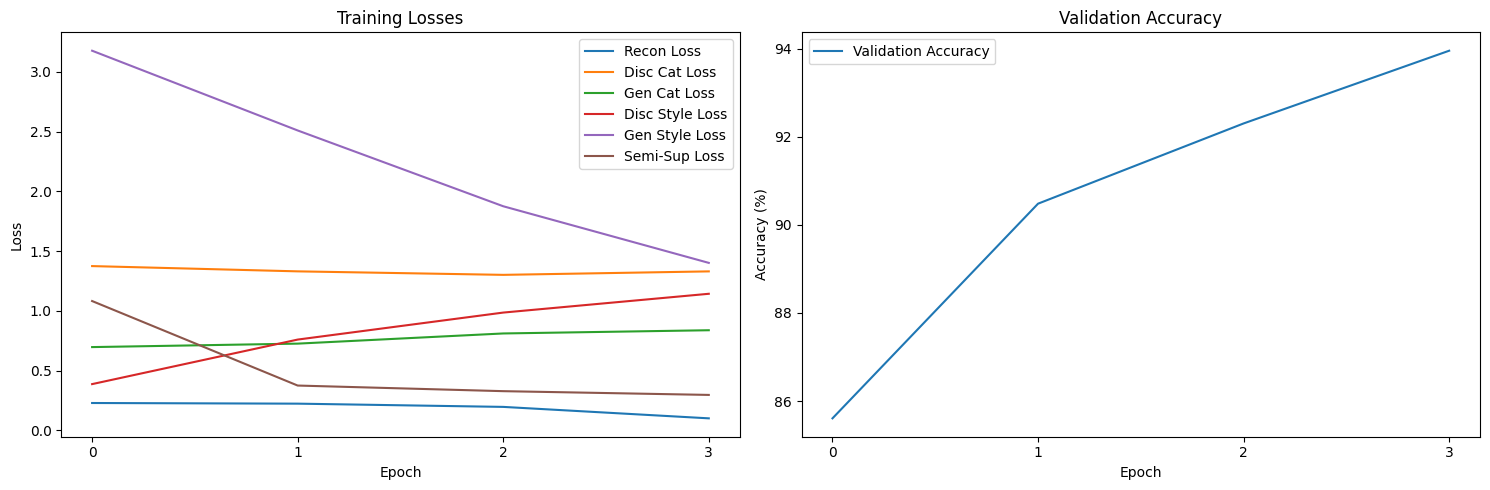

Epoch 1/4 — Recon: 0.2298, Disc_Cat: 1.3756, Gen_Cat: 0.6977, Disc_Style: 0.3879, Gen_Style: 3.1781, SemiSup: 1.0831
Validation Accuracy: 85.61%



Epoch [2/4]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 2/4 — Recon: 0.2243, Disc_Cat: 1.3315, Gen_Cat: 0.7267, Disc_Style: 0.7606, Gen_Style: 2.5106, SemiSup: 0.3759
Validation Accuracy: 90.48%



Epoch [3/4]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 3/4 — Recon: 0.1972, Disc_Cat: 1.3022, Gen_Cat: 0.8118, Disc_Style: 0.9866, Gen_Style: 1.8764, SemiSup: 0.3289
Validation Accuracy: 92.30%



Epoch [4/4]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 4/4 — Recon: 0.1014, Disc_Cat: 1.3313, Gen_Cat: 0.8388, Disc_Style: 1.1438, Gen_Style: 1.4025, SemiSup: 0.2975
Validation Accuracy: 93.95%



In [16]:
model.train_mbgd(
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=30,
    prior_std=PRIOR_STD,
)

In [17]:
all_probs, all_preds = [], []
for imgs, _ in test_loader:
    probs, preds = model.predict(imgs)
    all_probs.append(probs.cpu())
    all_preds.append(preds.cpu())

all_probs = torch.cat(all_probs, dim=0)
all_preds = torch.cat(all_preds, dim=0)

In [18]:
num_correct = torch.eq(all_preds, Y_test).sum().item()
accuracy = num_correct / Y_test.size(0)
print(f"Test accuracy: {accuracy*100:.2f}%")

Test accuracy: 94.26%


In [19]:
model.save_weights("run_1_weights/aae_weights")

Weights saved to run_1_weights/aae_weights_*.pth


## Image Generation

In [20]:
model.load_weights("run_1_weights/aae_weights")

Weights loaded from run_1_weights/aae_weights_*.pth


In [21]:
img7 = model.generate_images(2, prior_std=37.0)  

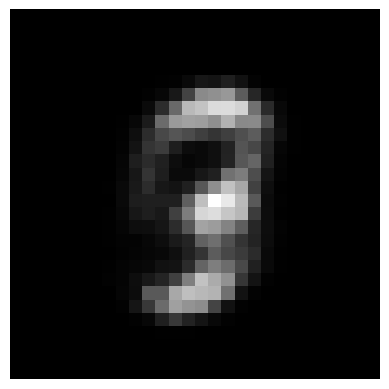

In [22]:
import matplotlib.pyplot as plt

plt.imshow(img7.squeeze().cpu().numpy(), cmap='gray')
plt.axis('off')
plt.show()